## Validation of model_predict_qubit_TransmonCross_cap_matrix wtih Ansys HFSS

In [1]:
from squadds import SQuADDS_DB
import pandas as pd
from squadds import Analyzer
import matplotlib.pyplot as plt
from squadds import AnsysSimulator

In [2]:
db = SQuADDS_DB()
db.select_system("qubit")
db.select_qubit("TransmonCross")
df = db.create_system_df()

We don't actually care about using SQuADDS to get a device at the moment, I just use the code block below to get a "template" of the SQUaDDS style dataframe.

In [3]:
analyzer = Analyzer(db)

# we are not actually looking for these Hamiltonian parameters... 
target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)

results = results.head(2) # we'll use this as our template frame we will overwrite!
results.index = [0,1]

In [4]:
ref_df = results[results.index == 0]
pred_df = results[results.index == 1]

## read in ML results and select sample to test

In [5]:
df_unscaled = pd.read_csv("predictions_and_errors_unscaled_one_hot.csv") # real in ML test results

In [6]:
sample = 7 # choose testing device from ML results

this_device = df_unscaled[df_unscaled.sample_idx == sample]

um = 10**6
# grab device params, convert back to microns, and add unit labels
ref_claw_length = str(this_device.ref_unscaled.iloc[0] * um)+'um'
ref_ground_spacing = str(this_device.ref_unscaled.iloc[1] * um)+'um'
ref_cross_length = str(this_device.ref_unscaled.iloc[2] * um)+'um'

pred_claw_length = str(this_device.pred_unscaled.iloc[0] * um)+'um'
pred_ground_spacing = str(this_device.pred_unscaled.iloc[1] * um)+'um'
pred_cross_length = str(this_device.pred_unscaled.iloc[2] * um)+'um'

### Substitute in ML results
There are only three multi-valued parameters in the SQuADDS qubit-TransmonCross-cap_matrix dataset:
* connection_pads.readout.claw_length
* connection_pads.readout.ground_spacing
* cross_length

The model only predicts these three parameters (for now). Below we take a SQuADDS database entry and substitute in the predicted parameters from the model.

In [7]:
ref_df.design_options.iloc[0]["connection_pads"]["readout"]["claw_length"] = ref_claw_length
ref_df.design_options.iloc[0]["connection_pads"]["readout"]["ground_spacing"] = ref_ground_spacing
ref_df.design_options.iloc[0]["cross_length"] = ref_cross_length

pred_df.design_options.iloc[0]["connection_pads"]["readout"]["claw_length"] = pred_claw_length
pred_df.design_options.iloc[0]["connection_pads"]["readout"]["ground_spacing"] = pred_ground_spacing
pred_df.design_options.iloc[0]["cross_length"] = pred_cross_length

In [8]:
ref_device = ref_df.iloc[0]
pred_device = pred_df.iloc[0]

## Simulate designs with Ansys HFSS

### Simulate reference device

In [10]:
ref_ansys_simulator = AnsysSimulator(analyzer, ref_device)

selected system: qubit


In [11]:
ref_ansys_results = ref_ansys_simulator.simulate(ref_device)

the parameters ['run'] are unsupported, so they have been ignored


INFO 01:58PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:58PM [load_ansys_project]: 	Opened Ansys App
INFO 01:58PM [load_ansys_project]: 	Opened Ansys Desktop v2023.2.0
INFO 01:58PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/firas/Documents/Ansoft/
	Project:   Project3
INFO 01:58PM [connect_design]: No active design found (or error getting active design).
INFO 01:58PM [connect]: 	 Connected to project "Project3". No design detected
INFO 01:58PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d [Solution type: Q3D]
WARNING 01:58PM [connect_setup]: 	No design setup detected.
WARNING 01:58PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:58PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:58PM [analyze]: Analyzing setup sweep_setup
INFO 02:00PM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppD

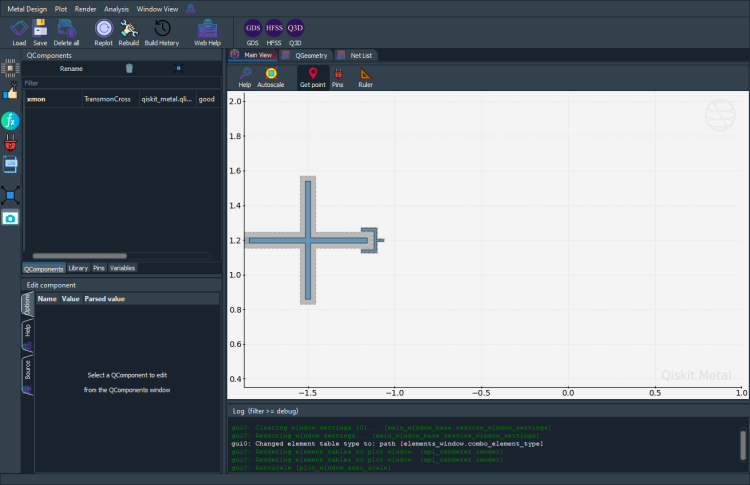

In [12]:
ref_ansys_simulator.get_design_screenshot()

In [13]:
ref_Hamiltonian_params = ref_ansys_simulator.get_xmon_info(ref_ansys_results)

qubit anharmonicity = -112 MHz 
qubit frequency = 3.589 GHz


### Simulate predicted device

In [14]:
pred_ansys_simulator = AnsysSimulator(analyzer, pred_device)

selected system: qubit


In [15]:
pred_ansys_results = pred_ansys_simulator.simulate(pred_device)

INFO 02:00PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:00PM [load_ansys_project]: 	Opened Ansys App
INFO 02:00PM [load_ansys_project]: 	Opened Ansys Desktop v2023.2.0
INFO 02:00PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/firas/Documents/Ansoft/
	Project:   Project3
INFO 02:00PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d [Solution type: Q3D]
INFO 02:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:00PM [connect]: 	Connected to project "Project3" and design "LOMv2.0_q3d" 😀 



the parameters ['run'] are unsupported, so they have been ignored


INFO 02:00PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d1 [Solution type: Q3D]
WARNING 02:00PM [connect_setup]: 	No design setup detected.
WARNING 02:00PM [connect_setup]: 	Creating Q3D default setup.
INFO 02:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:00PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:00PM [analyze]: Analyzing setup sweep_setup
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmpxgfqh5ap.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmpc7jcfiqe.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\firas\AppData\Local\Temp\17\tmpa1jcecz7.txt, C, , sweep_setup:AdaptiveP

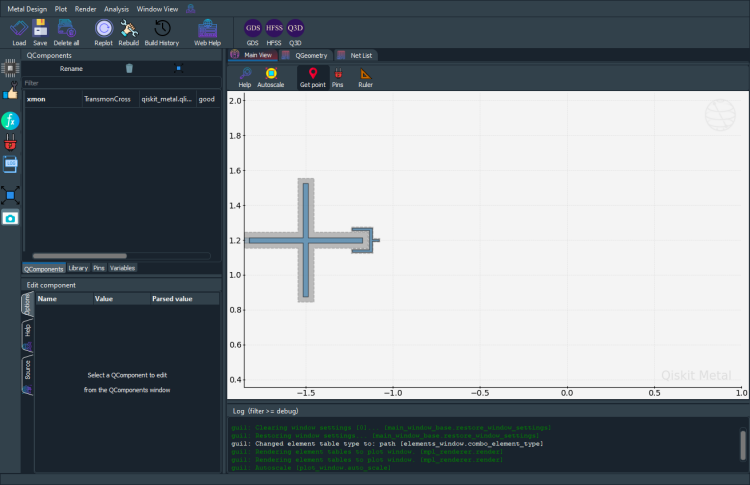

In [16]:
pred_ansys_simulator.get_design_screenshot()

In [17]:
pred_Hamiltonian_params = pred_ansys_simulator.get_xmon_info(pred_ansys_results)

qubit anharmonicity = -118 MHz 
qubit frequency = 3.669 GHz


## Saving data

In [18]:
testing_results = {
"sample":sample,
"ref_design":{"ref_claw_length":ref_claw_length,
             "ref_ground_spacing":ref_ground_spacing,
             "ref_cross_length":ref_cross_length},
"pred_design":{"pred_claw_length":pred_claw_length,
             "pred_ground_spacing":pred_ground_spacing,
             "pred_cross_length":pred_cross_length},
"ref_cap_matrix":ref_ansys_results["sim_results"],
"pred_cap_matrix":pred_ansys_results["sim_results"],
"ref_H_params":ref_Hamiltonian_params,
"pred_H_params":pred_Hamiltonian_params}


testing_frame = pd.DataFrame([testing_results])
testing_frame.to_csv("transmonCapMat_testing_sample{}.csv".format(sample)) # save data for later analysis